# Data Analysis Assignment - DPD Zero

### Steps:
1. Prepare
2. Process
3. Analyze

### Tasks:
1. Calculate risk labels for all the borrowers
2. Label all customers based on their tenure
3. Segment borrowers into 3 cohorts based on ticket size
4. Analyse spend recommendation to reduce overall bounce

---

In [1]:
#Importing libraries
import pandas as pd
import matplotlib.pyplot as plt

# Read the csv dataset
df = pd.read_csv('./Data_Analyst_Assignment_Dataset.csv')

print(df.head())
df.shape

   Amount Pending      State  Tenure  Interest Rate       City Bounce String  \
0             963  Karnataka      11           7.69  Bangalore           SSS   
1            1194  Karnataka      11           6.16  Bangalore           SSB   
2            1807  Karnataka      14           4.24     Hassan           BBS   
3            2451  Karnataka      10           4.70  Bangalore           SSS   
4            2611  Karnataka      10           4.41     Mysore           SSB   

   Disbursed Amount Loan Number  
0             10197       JZ6FS  
1             12738       RDIOY  
2             24640       WNW4L  
3             23990       6LBJS  
4             25590       ZFZUA  


(24582, 8)

In [2]:
#Clean the dataset: Checking for NA and duplicate values
df = df.dropna()
df = df.drop_duplicates()

In [3]:
df.shape

(24582, 8)

**This means there are no NA or duplicated values**

---

### Task 1: Calculate risk labels for all the borrowers

**Unknown Risk** - New customers

**Low Risk** - Customers who have not bounced in the last 6 months

**Medium Risk** - These are customers who have bounced at less than twice in the last 6 months - The bounce should not have occurred in the last month

**High risk** - Every other customer

### Solution: Analyzing the bounce string for all the customers

1. **Unknown Risk** - FEMI
2. **Low Risk** - 0 Bounce in the last 6 months
3. **Medium Risk** - 1 Bounce in the last 6 months with no bounce in the last month. (Here, I am not including 0 bounce since that is already covered in low risk and we are calculating the string for 6 months only)
4. **High Risk** - Rest all conditions

In [4]:
def calculate_risk_label(row):
    bounce_string = row['Bounce String']
    last_6_months = bounce_string[-6:]
    no_of_bounce = last_6_months.count('B') + last_6_months.count('L')
    
    if bounce_string == 'FEMI':
        return 'Unknown Risk'
    elif no_of_bounce == 0:
        return 'Low Risk'
    elif no_of_bounce == 1 and last_6_months[-1] not in ['B', 'L']:
        return 'Medium Risk'
    else:
        return 'High Risk'
    
df['Risk Label'] = df.apply(calculate_risk_label, axis=1)

In [5]:
print(df.head())

   Amount Pending      State  Tenure  Interest Rate       City Bounce String  \
0             963  Karnataka      11           7.69  Bangalore           SSS   
1            1194  Karnataka      11           6.16  Bangalore           SSB   
2            1807  Karnataka      14           4.24     Hassan           BBS   
3            2451  Karnataka      10           4.70  Bangalore           SSS   
4            2611  Karnataka      10           4.41     Mysore           SSB   

   Disbursed Amount Loan Number Risk Label  
0             10197       JZ6FS   Low Risk  
1             12738       RDIOY  High Risk  
2             24640       WNW4L  High Risk  
3             23990       6LBJS   Low Risk  
4             25590       ZFZUA  High Risk  


In [6]:
# Get the count for each type of risk
risk_count = df['Risk Label'].value_counts()
labels_ordered = ['Unknown Risk', 'Low Risk', 'Medium Risk', 'High Risk']
risk_count = risk_count.reindex(labels_ordered)

print(risk_count)

Unknown Risk     3222
Low Risk        13492
Medium Risk      2955
High Risk        4913
Name: Risk Label, dtype: int64


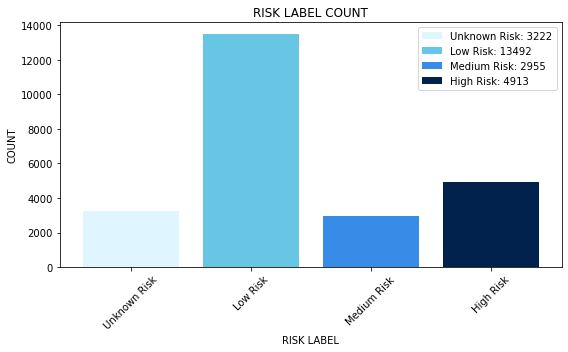

In [7]:
# Visualizing Count v/s Risk Label
plt.figure(figsize=(8, 5))
colors = ['#DFF5FF', '#67C6E3', '#378CE7', '#00224D']
bars = []

for i, label in enumerate(labels_ordered):
    bar = plt.bar(label, risk_count[label], color=colors[i])
    bars.append(bar)
    
legend_labels = [f'{label}: {risk_count[label]}' for label in labels_ordered]

plt.title('RISK LABEL COUNT')
plt.xlabel('RISK LABEL')
plt.ylabel('COUNT')
plt.xticks(rotation=45)
plt.legend(bars, legend_labels)
plt.tight_layout()
plt.show()

---

### Task 2: Label all customers based on their tenure

**Early Tenure** - Customers who are in the book for 3 months

**Late Tenure** - Customers who are 3 months away from closing the loan

**Mid Tenure** - Everyone else

### Solution: Analyzing the bounce string and tenure period for all the customers

Length of string denotes the total number of payments made by the customer. So SSSB (acc. to the document) implies the customer has made 4 payments and has been in the book for 5 months (since the first month is FEMI). Therefore, the **total number of months a customer has been in the book = Length of string + 1**.

1. **Early Tenure** - Bounce String = FEMI **and** Length of Bounce String <= 2
2. **Late Tenure** - Length of (Tenure - (Bounce String+1)) <= 3
3. **Mid Tenure** - Every other customer

In [8]:
def label_tenure(row):
    bounce_string = row['Bounce String']
    tenure = row['Tenure']
    
    # Adjusting bounce length to not count 'FEMI' and to be 0 if 'FEMI'
    if bounce_string == 'FEMI':
        bounce_length = 0
    else:
        bounce_length = len(bounce_string.replace('FEMI', ''))
    
    if bounce_string == 'FEMI' or bounce_length <= 2:
        return 'Early Tenure'
    elif tenure - (bounce_length + 1) <= 3:
        return 'Late Tenure'
    else:
        return 'Mid Tenure'

df['Tenure Label'] = df.apply(label_tenure, axis=1)

In [9]:
print(df.head())

   Amount Pending      State  Tenure  Interest Rate       City Bounce String  \
0             963  Karnataka      11           7.69  Bangalore           SSS   
1            1194  Karnataka      11           6.16  Bangalore           SSB   
2            1807  Karnataka      14           4.24     Hassan           BBS   
3            2451  Karnataka      10           4.70  Bangalore           SSS   
4            2611  Karnataka      10           4.41     Mysore           SSB   

   Disbursed Amount Loan Number Risk Label Tenure Label  
0             10197       JZ6FS   Low Risk   Mid Tenure  
1             12738       RDIOY  High Risk   Mid Tenure  
2             24640       WNW4L  High Risk   Mid Tenure  
3             23990       6LBJS   Low Risk   Mid Tenure  
4             25590       ZFZUA  High Risk   Mid Tenure  


In [10]:
# Get the count for each type of tenure
tenure_state = df['Tenure Label'].value_counts()
labels_ordered = ['Early Tenure', 'Mid Tenure', 'Late Tenure']
tenure_state = tenure_state.reindex(labels_ordered)

print(tenure_state)

Early Tenure    12240
Mid Tenure       5324
Late Tenure      7018
Name: Tenure Label, dtype: int64


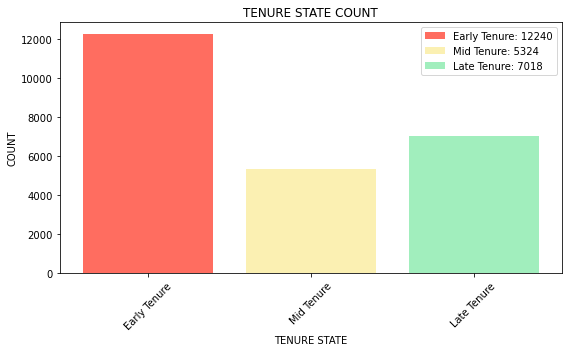

In [11]:
# Visualizing Count v/s Tenure State
plt.figure(figsize=(8, 5))
colors = ['#FF6D60', '#FBF0B2', '#A1EEBD']
bars = []

for i, label in enumerate(labels_ordered):
    bar = plt.bar(label, tenure_state[label], color=colors[i])
    bars.append(bar)
    
legend_labels = [f'{label}: {tenure_state[label]}' for label in labels_ordered]

plt.title('TENURE STATE COUNT')
plt.xlabel('TENURE STATE')
plt.ylabel('COUNT')
plt.xticks(rotation=45)
plt.legend(bars, legend_labels)
plt.tight_layout()
plt.show()

---

### Task 3: Segment borrowers into 3 cohorts based on ticket size

**Low ticket size**

**Medium ticket size**

**High ticket size**

Sum of amount pending in each cohort should be approximately equal. 

### Solution: Analyzing the amount pending for all the customers

For this problem, I will first sort the amount pending for each customer in ascending order. This is required for categorization. Then I will find out the sum and divide it roughly in 3 equal parts. The first part will then be for low ticket size, second for medium and third will be for high ticket size. Then I will get the count and order the data frame based on the ticket sizes.

In [12]:
df_sorted = df.sort_values(by='Amount Pending')
print(df_sorted.head())

      Amount Pending        State  Tenure  Interest Rate          City  \
1534             423  Maharashtra      11          11.84        Sangli   
1982             444   Tamil Nadu      11          12.23  VIRUDHUNAGAR   
889              451  Maharashtra       7          37.92          Pune   
265              522    Karnataka      11          12.83      Bagalkot   
1486             522  Maharashtra      11          12.83          Pune   

     Bounce String  Disbursed Amount Loan Number    Risk Label  Tenure Label  
1534          FEMI              4389       HEMS0  Unknown Risk  Early Tenure  
1982          FEMI              4598       1BYJD  Unknown Risk  Early Tenure  
889         LSSSSB              2793       7COLC     High Risk   Late Tenure  
265           FEMI              5390       587TX  Unknown Risk  Early Tenure  
1486             S              5390       5QJN0      Low Risk  Early Tenure  


In [13]:
total_amount_pending = df_sorted['Amount Pending'].sum()
distribute_low = total_amount_pending/3
distribute_medium = 2 * total_amount_pending/3

sum_current = 0
low_idx, medium_idx, high_idx = [], [], []

for idx, row in df_sorted.iterrows():
    sum_current += row['Amount Pending']
    if sum_current <= distribute_low:
        low_idx.append(idx)
    elif sum_current <= distribute_medium:
        medium_idx.append(idx)
    else:
        high_idx.append(idx)

df_sorted.loc[low_idx, 'Ticket Size'] = 'Low Ticket Size'
df_sorted.loc[medium_idx, 'Ticket Size'] = 'Medium Ticket Size'
df_sorted.loc[high_idx, 'Ticket Size'] = 'High Ticket Size'

sum_low = df_sorted[df_sorted['Ticket Size'] == 'Low Ticket Size']['Amount Pending'].sum()
sum_medium = df_sorted[df_sorted['Ticket Size'] == 'Medium Ticket Size']['Amount Pending'].sum()
sum_high = df_sorted[df_sorted['Ticket Size'] == 'High Ticket Size']['Amount Pending'].sum()
print(f"Sum_Low: {sum_low}\nSum_Medium: {sum_medium}\nSum_High: {sum_high}\n")

print(df_sorted.head())

Sum_Low: 14676828
Sum_Medium: 14676862
Sum_High: 14676917

      Amount Pending        State  Tenure  Interest Rate          City  \
1534             423  Maharashtra      11          11.84        Sangli   
1982             444   Tamil Nadu      11          12.23  VIRUDHUNAGAR   
889              451  Maharashtra       7          37.92          Pune   
265              522    Karnataka      11          12.83      Bagalkot   
1486             522  Maharashtra      11          12.83          Pune   

     Bounce String  Disbursed Amount Loan Number    Risk Label  Tenure Label  \
1534          FEMI              4389       HEMS0  Unknown Risk  Early Tenure   
1982          FEMI              4598       1BYJD  Unknown Risk  Early Tenure   
889         LSSSSB              2793       7COLC     High Risk   Late Tenure   
265           FEMI              5390       587TX  Unknown Risk  Early Tenure   
1486             S              5390       5QJN0      Low Risk  Early Tenure   

          Ticke

In [14]:
# Get the count for each type of ticket
ticket_size = df_sorted['Ticket Size'].value_counts()
labels_ordered = ['Low Ticket Size', 'Medium Ticket Size', 'High Ticket Size']
ticket_size = ticket_size.reindex(labels_ordered)

print(ticket_size)

Low Ticket Size       12296
Medium Ticket Size     7731
High Ticket Size       4555
Name: Ticket Size, dtype: int64


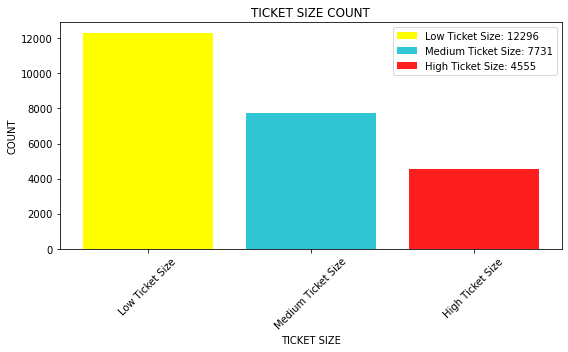

In [15]:
# Visualizing Count v/s Ticket Size
plt.figure(figsize=(8, 5))
colors = ['#FFFF00', '#31C6D4', '#FF1E1E']
bars = []

for i, label in enumerate(labels_ordered):
    bar = plt.bar(label, ticket_size[label], color=colors[i])
    bars.append(bar)
    
legend_labels = [f'{label}: {ticket_size[label]}' for label in labels_ordered]

plt.title('TICKET SIZE COUNT')
plt.xlabel('TICKET SIZE')
plt.ylabel('COUNT')
plt.xticks(rotation=45)
plt.legend(bars, legend_labels)
plt.tight_layout()
plt.show()

---

### Task 4: Analyse spend recommendation to reduce overall bounce

**Digital Medium** - ₹5 per borrower

    Customers with great repayment behavior
    Customers with first EMIs
    Customers who have low EMIs

**Voice Bot Medium** - ₹10 per borrower

    Customer who know Hindi or English - Metropolitan areas have high probability of english speakers
    Customers who have had low bounce behaviour
    Customers with low or medium sized EMIs

**Telecalling** - ₹50 per borrower

    Telecalling will work on all scenarios but is the costliest option

Target: Segment the borrowers into these 3 channels of spend category and minimise the overall spend while maximise on time repayment.

### Solution: Analyzing the previous solutions and recommending based on the given conditions

1. **WhatsApp Bot Medium** - Customers with FEMI or low risk and low ticket size
2. **Voice Bot Medium** - Customers in metro, low to medium risk and ticket size
3. **Telecalling** - Everyone else.

For Voice Bot Medium, I will first find out the states and their cities. From that, assumption is made that metro cities will be the capitals and major cities in the states apart from capitals.

In [16]:
# Grab the unique state and city values
state_city_mapping = df.groupby('State')['City'].unique().reset_index()
state_city_mapping['City'] = state_city_mapping['City'].apply(', '.join)
state_city_mapping['City Count'] = df.groupby('State')['City'].nunique().reset_index()['City']
print(state_city_mapping)

            State                                               City  \
0  Andhra Pradesh  Guntur, Cuddapah, Krishna, Chittoor, Prakasam,...   
1       Karnataka  Bangalore, Hassan, Mysore, DAKSHINA KANNADA, B...   
2          Kerala  Kollam, Kannur, Thrissur, Palakkad, Pathanamth...   
3  Madhya Pradesh  Vidisha, Rewa, Damoh, Sidhi, Chhatarpur, Indor...   
4     Maharashtra  Sindhudurg, Pune, Sangli, YAVATMAL, Jalgaon, A...   
5      Tamil Nadu  NAGAPATTINAM, Tirunelveli, Madurai, TIRUVALLUR...   
6       Telangana  Hyderabad, Mahabub Nagar, Nalgonda, Warangal, ...   

   City Count  
0          14  
1          30  
2          15  
3          49  
4          36  
5          33  
6          10  


In [17]:
print(df_sorted['City'].nunique())

186


#### Selecting cities for Voice Bot Medium
1. State Capitals: **Amravati, Bangalore, Mumbai, Chennai, Hyderabad** (Excluded Bhopal and Thiruvananthapuram)
2. All the cities of **Madhya Pradesh** since it is primarily a Hindi speaking state.
3. All the cities of **Kerala** since it is the most literate state, i.e., most of them can be safely assumed to speak English.
4. Big Cities: Cities which are culturally and economically important but are not the capitals of their respective states - 

a. Andhra Pradesh - Visakhapatnam, Pondicherry*

b. Karnataka - Bangalore Rural, Mysore

c. Maharashtra - Nagpur, Pune, Aurangabad, Thane, North Goa, South Goa

d. Tamil Nadu - Madurai, Coimbatore, Vellore, Pondicherry*

e. Telangana - Warangal

#### Total Cities in consideration = 83

**However, since our aim is to reduce the costs, we will first focus maximizing digital medium and then try to maximize voice bot medium wherein again we will target risk and ticket size prior to targetting cities.**

In [18]:
voice_bot_cities = [
    'Amravati', 'Bangalore', 'Mumbai', 'Chennai', 'Hyderabad', 'Visakhapatnam', 'Pondicherry', 'BANGALORE RURAL', 'Mysore', 'Nagpur', 'Pune', 'Aurangabad', 'Thane', 'NORTH GOA', 'SOUTH GOA', 'Madurai', 'Coimbatore', 'VELLORE', 'Warangal'
]
def update_voice_bot_cities(df_sorted):
    # Extract unique cities from Madhya Pradesh and Kerala
    mp_kerala_cities = df[df['State'].isin(['Madhya Pradesh', 'Kerala'])]['City'].unique().tolist()
    
    global voice_bot_cities
    voice_bot_cities = list(set(voice_bot_cities + mp_kerala_cities))
    
    voice_bot_cities.sort()

update_voice_bot_cities(df_sorted)

print(len(voice_bot_cities))
print(voice_bot_cities)

83
['ANUPPUR', 'ASHOK NAGAR', 'Alappuzha', 'Amravati', 'Aurangabad', 'BANGALORE RURAL', 'BARWANI', 'BURHANPUR', 'Balaghat', 'Bangalore', 'Betul', 'Bhind', 'Bhopal', 'Chennai', 'Chhatarpur', 'Chhindwara', 'Coimbatore', 'Damoh', 'Datia', 'Dewas', 'Dhar', 'East Nimar', 'Ernakulam', 'Guna', 'Gwalior', 'HARDA', 'Hoshangabad', 'Hyderabad', 'IDUKKI', 'Indore', 'Jabalpur', 'Jhabua', 'KASARGOD', 'KATNI', 'Kannur', 'Khandwa', 'Kollam', 'Kottayam', 'Kozhikode', 'MAHE', 'MALAPPURAM', 'Madurai', 'Mandla', 'Mandsaur', 'Morena', 'Mumbai', 'Mysore', 'NORTH GOA', 'Nagpur', 'Narsinghpur', 'Neemuch', 'Palakkad', 'Panna', 'Pathanamthitta', 'Pondicherry', 'Pune', 'Raisen', 'Rajgarh', 'Ratlam', 'Rewa', 'SHEOPUR', 'SOUTH GOA', 'Sagar', 'Satna', 'Sehore', 'Seoni', 'Shahdol', 'Shajapur', 'Shivpuri', 'Sidhi', 'Singrauli', 'Thane', 'Thiruvananthapuram', 'Thrissur', 'Tikamgarh', 'UMARIA', 'Ujjain', 'VELLORE', 'Vidisha', 'Visakhapatnam', 'Warangal', 'Wayanad', 'West Nimar']


In [19]:
df_sorted['Spend Category'] = None

# Calculating no. of rows for whatsApp bot medium:
df_sorted.loc[(df_sorted['Bounce String'].str.startswith('F')) | (df_sorted['Ticket Size'] == 'Low Ticket Size') | (df_sorted['Risk Label'] == 'Low Risk'), 'Spend Category'] = 'WhatsApp Bot'

# Calculating no.of rows for voice bot medium:
df_sorted.loc[(df_sorted['Spend Category'].isnull()) & ((df_sorted['City'].isin(voice_bot_cities)) | (df_sorted['Risk Label'] == 'Medium Risk') | (df_sorted['Ticket Size'] == 'Medium Ticket Size')), 'Spend Category'] = 'Voice Bot'

# Assigning remaining no. of rows for telecalling medium:
df_sorted.loc[df_sorted['Spend Category'].isnull(), 'Spend Category'] = 'Telecalling'

print(df_sorted.head())

      Amount Pending        State  Tenure  Interest Rate          City  \
1534             423  Maharashtra      11          11.84        Sangli   
1982             444   Tamil Nadu      11          12.23  VIRUDHUNAGAR   
889              451  Maharashtra       7          37.92          Pune   
265              522    Karnataka      11          12.83      Bagalkot   
1486             522  Maharashtra      11          12.83          Pune   

     Bounce String  Disbursed Amount Loan Number    Risk Label  Tenure Label  \
1534          FEMI              4389       HEMS0  Unknown Risk  Early Tenure   
1982          FEMI              4598       1BYJD  Unknown Risk  Early Tenure   
889         LSSSSB              2793       7COLC     High Risk   Late Tenure   
265           FEMI              5390       587TX  Unknown Risk  Early Tenure   
1486             S              5390       5QJN0      Low Risk  Early Tenure   

          Ticket Size Spend Category  
1534  Low Ticket Size   WhatsApp Bo

In [20]:
# Get the count for each type of medium
medium = df_sorted['Spend Category'].value_counts()
labels_ordered = ['WhatsApp Bot', 'Voice Bot', 'Telecalling']
medium = medium.reindex(labels_ordered)

print(medium)

WhatsApp Bot    20787
Voice Bot        3424
Telecalling       371
Name: Spend Category, dtype: int64


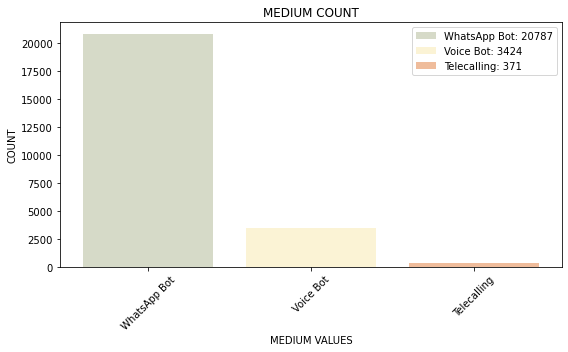

In [21]:
# Visualizing Count v/s Medium
plt.figure(figsize=(8, 5))
colors = ['#D6DAC8', '#FBF3D5', '#EFBC9B']
bars = []

for i, label in enumerate(labels_ordered):
    bar = plt.bar(label, medium[label], color=colors[i])
    bars.append(bar)
    
legend_labels = [f'{label}: {medium[label]}' for label in labels_ordered]

plt.title('MEDIUM COUNT')
plt.xlabel('MEDIUM VALUES')
plt.ylabel('COUNT')
plt.xticks(rotation=45)
plt.legend(bars, legend_labels)
plt.tight_layout()
plt.show()

In [23]:
# Get the total cost
costs = {'WhatsApp Bot': 5, 'Voice Bot': 10, 'Telecalling': 50}
adjusted_counts = medium * [costs[label] for label in labels_ordered]
cost_table = pd.DataFrame({'Count': medium, 'Adjusted Count': adjusted_counts})

total_count = cost_table['Count'].sum()
total_adjusted_count = cost_table['Adjusted Count'].sum()
cost_table.loc['Total'] = [total_count, total_adjusted_count]

print(cost_table)

              Count  Adjusted Count
WhatsApp Bot  20787          103935
Voice Bot      3424           34240
Telecalling     371           18550
Total         24582          156725


#### Therefore, total cost incurred is ₹ 1,56,725